In [1]:
version = 'v20250521'

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
from sklearn.ensemble import RandomForestRegressor, IsolationForest
import joblib
import numpy as np

random_state = 42

## Calculate SNR, error, |error|, signal and RAE for c, $\delta$ and $\beta$

In [2]:
pnt = pd.read_parquet(f'./metric/point_predicted_{version}.pq')
name_map = {'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'ndvi',
            'ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218':'ndwi'}

pnt = pnt.rename(columns = name_map)
            
for col in ['ndvi','ndwi']:
    pnt[col] = (pnt[col]-125)/125
    
# calculate snr, error and abs_error for each pnt
pnt['snr'] = pnt['pred']/pnt['pred_std']
pnt['error'] = pnt['pred'] - pnt['soc']
pnt['abs_error'] = pnt['error'].abs()
pnt['signal'] = pnt['pred'].abs()
pnt['rae'] = pnt['abs_error']/pnt['soc']

In [3]:
pair = pd.read_parquet(f'./metric/pair_predicted_{version}.pq')
pair = pair.drop(columns=['time_pair_y','lc_survey_pair_x','pred_pair'])
pair = pair.rename(columns={'pred_change_pnt':'pred_pnt','pred':'pred_pair','pred_std':'noise_pair',
                            'time_pair_x':'time_pair','lc_survey_pair_y':'lc_survey_pair'})
pair['signal_pnt'] = pair['pred_pnt'].abs()
pair['signal_pair'] = pair['pred_pair'].abs()
pair['snr_pnt'] = pair['signal_pnt']/pair['noise_pnt']
pair['snr_pair'] = pair['signal_pair']/pair['noise_pair']
pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]
pair['error'] = pair['pred_pnt'] - pair['soc_change']
pair['abs_error'] = pair['error'].abs()
pair['rae'] = pair['abs_error']/(pair['soc_change'].abs()+0.001)
# pair.loc[pair['soc_change'].abs()<1, 'rae'] =  pair.loc[pair['soc_change'].abs()<1, 'abs_error'] # "normalize" rae, with detectability floor == 1

In [4]:
srs = pd.read_parquet(f'./metric/srs_predicted_{version}.pq')
srs = srs[srs.columns[0:21].tolist()+srs.columns[-24::].tolist()]

srs = srs.rename(columns={'slope_pred':'pred_pnt', 'slope_std':'noise_pnt','pred':'pred_srs','pred_std':'noise_srs'})
srs['signal_pnt'] = srs['pred_pnt'].abs()
srs['signal_srs'] = srs['pred_srs'].abs()
srs['snr_pnt'] = srs['signal_pnt']/srs['noise_pnt']
srs['snr_srs'] = srs['signal_srs']/srs['noise_srs']
srs['error'] = srs['pred_pnt'] - srs['slope_obsv']
srs['rae'] = srs['error'].abs()/(srs['slope_obsv'].abs()+0.001)
srs['abs_error'] = srs['error'].abs()
# srs.loc[srs['slope_obsv'].abs()<0.5, 'rae'] =  srs.loc[srs['slope_obsv'].abs()<0.5, 'abs_error']/0.5

## RAE vs. SNR

To explore the relationship between internal model confidence (SNR) and actual predictive accuracy, we compared SNR with relative absolute error for each $\hat{\delta}$ and $\hat{\beta}$ in the validation dataset. 

Relative absolute error (RAE) was used to evaluate prediction accuracy across all target variables ($c$, $\delta$, and $\beta$). It is defined as the absolute difference between the predicted and observed values, normalized by the observed value. 

To avoid numerical instability when observed values are near zero, a small constant (0.001) is added to the denominator:

$$
RAE = \frac{\hat{y} - y}{y + 0.001}
$$

where $y$ denotes the observed value (e.g., $\delta$ or $\beta$) and $\hat{y}$ the corresponding model prediction.

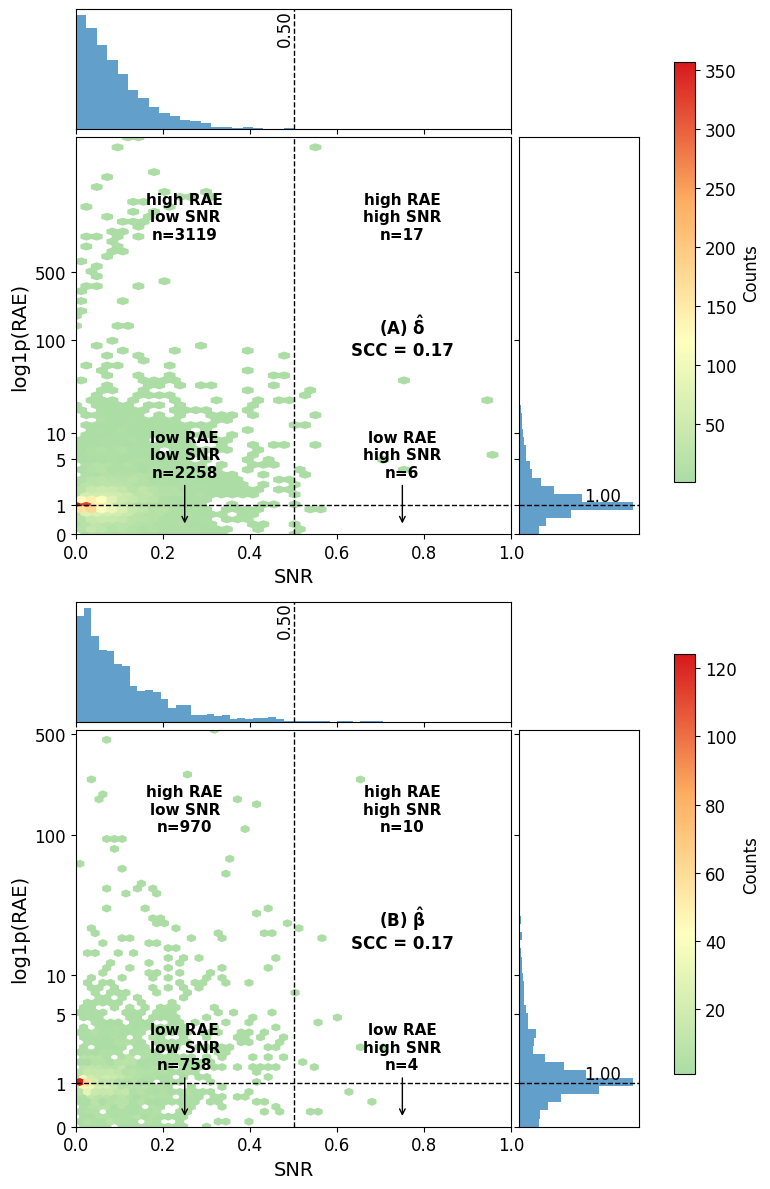

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable


# ──────────────────────────────────────────────────────────────────
# 1.  CONSTANTS
# -----------------------------------------------------------------
cmap_cet_l19 = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)
Q_SNR, Q_RAE = 0.5, 1.0          # vertical & horizontal cut-offs (orig. units)
Y_TICKS_ORIG = np.array([0, 1, 5, 10, 100, 500])  # labels you want to show
Y_TICKS_PLOT = np.log1p(Y_TICKS_ORIG)             # where they sit after log1p
YTICK_LABELS = [str(v) for v in Y_TICKS_ORIG]

# ──────────────────────────────────────────────────────────────────
# 2.  SMALL HELPER FUNCTION  – draws ONE panel on supplied axes
# -----------------------------------------------------------------
def joint_hex_panel(ax_main, data, panel_code, metric_text,
                    cmap=cmap_cet_l19, gridsize=(40, 40)):
    """Draw joint hex-bin + marginal histograms on ax_main & its twin axes."""
    # ----- create marginal axes
    divider   = make_axes_locatable(ax_main)
    ax_top    = divider.append_axes("top",   1.2, pad=0.08, sharex=ax_main)
    ax_right  = divider.append_axes("right", 1.2, pad=0.08, sharey=ax_main)

    plt.setp(ax_top.get_xticklabels(),   visible=False)
    plt.setp(ax_right.get_yticklabels(), visible=False)

    # ----- log1p-transform only for plotting geom
    y_log = np.log1p(data["rae"])
    q_rae_plot = np.log1p(Q_RAE)

    # ----- main hex-bin
    hb = ax_main.hexbin(
        data["snr_pnt"], y_log,
        gridsize=gridsize, cmap=cmap, mincnt=1,
    )
    ax_main.axvline(Q_SNR,      ls="--", lw=1, c="k")
    ax_main.axhline(q_rae_plot, ls="--", lw=1, c="k")
    ax_main.set_xlim(0, 1)
    ax_main.set_ylim(y_log.min(), y_log.max())
    ax_main.set_xlabel("SNR", fontsize=14)
    ax_main.set_ylabel("log1p(RAE)", fontsize=14)
    ax_main.set_yticks(Y_TICKS_PLOT)
    ax_main.set_yticklabels(YTICK_LABELS, fontsize=12)
    ax_main.tick_params(axis='x', which='major', labelsize=12)

    cbar = ax_main.figure.colorbar(
        hb, ax=ax_main, shrink=0.8, label="Counts"
    )
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("Counts", fontsize=12)

    # ----- top histogram
    ax_top.hist(
        data["snr_pnt"], bins=40, density=True,
        histtype="stepfilled", alpha=0.7,
    )
    ax_top.axvline(Q_SNR, ls="--", lw=1, c="k")
    ax_top.text(
        Q_SNR, ax_top.get_ylim()[1]*0.85, f"{Q_SNR:.2f}",
        ha="right", va="center", rotation=90, fontsize=12
    )
    ax_top.yaxis.set_visible(False)

    # ----- right histogram
    ax_right.hist(
        y_log, bins=np.linspace(y_log.min(), y_log.max(), 50),
        orientation="horizontal", density=True,
        histtype="stepfilled", alpha=0.7
    )
    ax_right.axhline(q_rae_plot, ls="--", lw=1, c="k")
    ax_right.text(
        ax_right.get_xlim()[1]*0.85, q_rae_plot,
        f"{Q_RAE:.2f}", ha="right", va="bottom", fontsize=12
    )
    ax_right.set_yticks(Y_TICKS_PLOT)
    ax_right.set_yticklabels(YTICK_LABELS, fontsize=12)
    ax_right.xaxis.set_visible(False)

    # ----- quadrant counts on *original* scale
    hi_snr = data["snr_pnt"] >= Q_SNR
    hi_rae = data["rae"]     >= Q_RAE
    lo_snr = ~hi_snr
    lo_rae = ~hi_rae
    counts = {
        "HH": (hi_rae & hi_snr).sum(),
        "HL": (hi_rae & lo_snr).sum(),
        "LH": (lo_rae & hi_snr).sum(),
        "LL": (lo_rae & lo_snr).sum(),
    }
    ax_main.text(0.75, 0.80, f"high RAE\nhigh SNR\nn={counts['HH']}",
                 transform=ax_main.transAxes, ha="center", va="center",
                 weight="bold", fontsize=11)
    ax_main.text(0.25, 0.80, f"high RAE\nlow SNR\nn={counts['HL']}",
                 transform=ax_main.transAxes, ha="center", va="center",
                 weight="bold", fontsize=11)
    ax_main.text(0.75, 0.20, f"low RAE\nhigh SNR\nn={counts['LH']}",
                 transform=ax_main.transAxes, ha="center", va="center",
                 weight="bold", fontsize=11)
    ax_main.annotate("", xy=(0.75, 0.02), xytext=(0.75, 0.13),
                     xycoords="axes fraction", textcoords="axes fraction",
                     arrowprops=dict(arrowstyle="->", lw=1))
    ax_main.text(0.25, 0.20, f"low RAE\nlow SNR\nn={counts['LL']}",
                 transform=ax_main.transAxes, ha="center", va="center",
                 weight="bold", fontsize=11)
    ax_main.annotate("", xy=(0.25, 0.02), xytext=(0.25, 0.13),
                     xycoords="axes fraction", textcoords="axes fraction",
                     arrowprops=dict(arrowstyle="->", lw=1))

    # ----- panel label
    ax_main.text(
        0.75, 0.50,
        rf"({panel_code}) $\mathbf{{{metric_text}}}$" + "\n" + "SCC = 0.17",
        transform=ax_main.transAxes, ha="center", va="center",
        fontsize=12, fontweight="bold"
    )

    # ──────────────────────────────────────────────────────────────────
# 3.  CREATE THE 2×1 FIGURE  &  DRAW BOTH PANELS
# -----------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 12), sharex=False, sharey=False
)

joint_hex_panel(axes[0], pair, "A", r"\hat{\delta}")
joint_hex_panel(axes[1], srs,  "B", r"\hat{\beta}")

plt.tight_layout()
plt.savefig("./figure/plot_compare_snr.rae.pdf", bbox_inches="tight")
plt.show()


### Plot description

Density plots of RAE versus SNR for both $\hat{\delta}$ (A) and $\hat{\beta}$ (B), quantified using the state-firstbapproach. 

RAE is shown on a $\log_{1p}$ scale to enhance visibility of lower values. Each plot is divided into four quadrants using thresholds of RAE = 1 and SNR = 0.5, representing: high RAE and low SNR, high RAE and high SNR, low RAE and low SNR, and low RAE and high SNR. 

Marginal distributions, the distribution of individual variables without conditioning on others, are displayed along the top and right axes. The Spearman correlation coefficient (SCC) between RAE and SNR is indicated in each plot.

### Results analysis

The Spearman correlation coefficient (SCC) was used to assess the relationship between SNR and RAE. As a rank-based measure of monotonic association, values closer to 1 or –1 indicate stronger positive or negative relationships, respectively. 

This shows that predictions with high SNR do not necessarily exhibit higher accuracy for either $\hat{\delta}$ (SCC = 0.17) or $\hat{\beta}$ (SCC = 0.17), indicating only a weak positive correlation between SNR and RAE. 

For both targets, the SNR is usually below one while the RAE centers around one. The majority of predictions fall into the "high RAE and low SNR" quadrant, followed by "low RAE and low SNR", "high RAE and high SNR", and lastly "low RAE and high SNR". 

## Calculate coefficient between them

In [9]:
srs[['rae','abs_error','snr_srs','snr_pnt']].corr(method='spearman')

,rae,abs_error,snr_srs,snr_pnt
rae,1.000000,0.224676,-0.009347,0.172979
abs_error,0.224676,1.000000,0.343817,0.012202
snr_srs,-0.009347,0.343817,1.000000,-0.124610
snr_pnt,0.172979,0.012202,-0.124610,1.000000


In [6]:
srs[['rae','abs_error','snr_srs','snr_pnt']].corr(method='pearson')

,rae,abs_error,snr_srs,snr_pnt
rae,1.000000,-0.014010,0.045039,0.126493
abs_error,-0.014010,1.000000,0.210908,0.006699
snr_srs,0.045039,0.210908,1.000000,-0.098626
snr_pnt,0.126493,0.006699,-0.098626,1.000000


In [10]:
pair[['rae','abs_error','snr_pair','snr_pnt']].corr(method='spearman')

,rae,abs_error,snr_pair,snr_pnt
rae,1.000000,0.204387,-0.015979,0.171816
abs_error,0.204387,1.000000,0.330610,0.068549
snr_pair,-0.015979,0.330610,1.000000,-0.039289
snr_pnt,0.171816,0.068549,-0.039289,1.000000


In [8]:
pair[['rae','abs_error','snr_pair','snr_pnt']].corr(method='pearson')

,rae,abs_error,snr_pair,snr_pnt
rae,1.000000,-0.016706,0.005207,0.058740
abs_error,-0.016706,1.000000,0.181889,0.000736
snr_pair,0.005207,0.181889,1.000000,-0.005883
snr_pnt,0.058740,0.000736,-0.005883,1.000000


## srs

In [2]:

# params
prop = 'slope'
tgt = 'ts_slope'
space = 'normal'

# covs
covs = pd.read_csv(f'./metric/feature_selected_{prop}_{version}.txt', header=None)[0].tolist() 
# train data
train = pd.read_parquet(f'./material/srs_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
# test
srs = pd.read_parquet(f'./metric/srs_predicted.srs_{version}.pq')
# train isolation forest
isof = IsolationForest(random_state=random_state)
isof.fit(train[covs])

iso_class = isof.predict(srs[covs])
srs['Anomaly'] = isof.decision_function(srs[covs]) # inlier -> 0, outlier -> -1
srs['Anomaly'] = srs['Anomaly']*(-1) # inlier -> 0, outlier -> 1, the higher the score is, the more abnormal it is

In [3]:
srs['signal'] = srs['ts_slope'].abs()
srs = srs.rename(columns={'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_20000101_20001231_eu_epsg.3035_v20231127_full_mean':'NDVI','pred_std':'noise_srs'})
srs['SNR'] = srs['signal']/srs['noise_srs']
srs['SOC'] = srs['soc_series'].apply(lambda x: np.mean(x))

In [4]:
srs['error'] = srs['pred'] - srs[tgt]
srs[r'RAE'] = srs['error'].abs()/srs['signal'] #$Error_{\mathrm{abs}}$

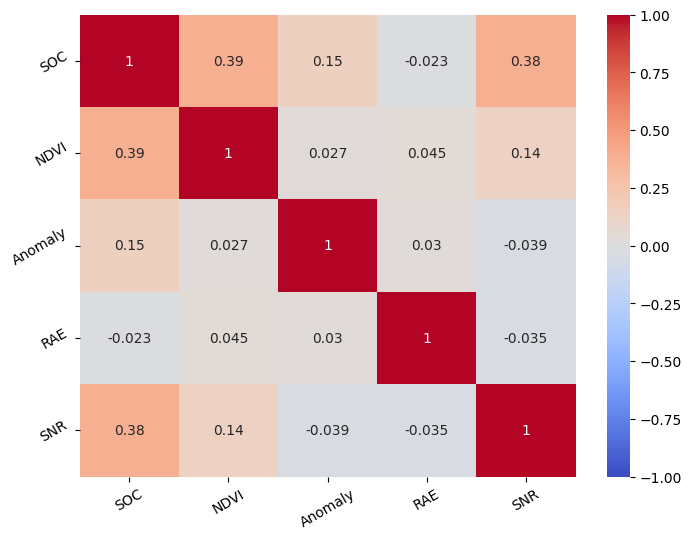

In [5]:
coe_srs = srs[['SOC','NDVI','Anomaly',r'RAE','SNR']].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe_srs, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=30)
# plt.savefig(f'./figure/plot_corr_pair.metrics.pdf', bbox_inches='tight')
plt.show()

## pair

In [6]:
# params
prop = 'change'
tgt = 'soc_change'
space = 'normal'

# covs
covs = pd.read_csv(f'./metric/feature_selected_{prop}_{version}.txt', header=None)[0].tolist() 
# train data
train = pd.read_parquet(f'./material/pair_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
# test
pair = pd.read_parquet(f'./metric/pair_predicted.pair_{version}.pq')
# train isolation forest
isof = IsolationForest(random_state=random_state)
isof.fit(train[covs])

iso_class = isof.predict(pair[covs])
pair['Anomaly'] = isof.decision_function(pair[covs]) 
pair['Anomaly'] = pair['Anomaly']*(-1) 

In [7]:
pair = pair.rename(columns={'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_20000101_20001231_eu_epsg.3035_v20231127_full_mean':'NDVI','pred_std':'noise_pair','soc_mean':'SOC'})
pair['signal'] = pair['soc_change'].abs()
pair['SNR'] = pair['signal']/pair['noise_pair']

pair['error'] = pair['pred'] - pair[tgt]
pair[r'RAE'] = pair['error'].abs()/pair['signal']

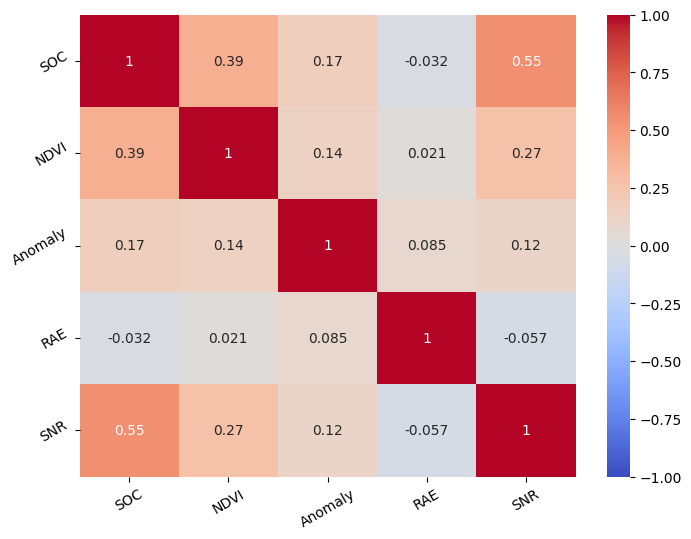

In [8]:
coe_pair = pair[['SOC','NDVI','Anomaly',r'RAE','SNR']].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe_pair, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=30)
# plt.savefig(f'./figure/plot_corr_pair.metrics.pdf', bbox_inches='tight')
plt.show()

## point

In [9]:
prop = 'soc'
tgt = 'soc_log1p'

covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/pnt_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
test = pd.read_parquet(f'./metric/point_predicted_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)

# train isolation forest
isof = IsolationForest(random_state=random_state)
isof.fit(train[covs])

iso_class = isof.predict(test[covs])
test['Anomaly'] = isof.decision_function(test[covs]) 
test['Anomaly'] = test['Anomaly']*(-1) 

In [10]:
test = test.rename(columns={'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'NDVI','soc':'SOC'})
test['SNR'] = test['SOC']/test['pred_std']
test['error'] = test['pred'] - test['SOC']
test[r'RAE'] = test['error'].abs()/test['SOC']

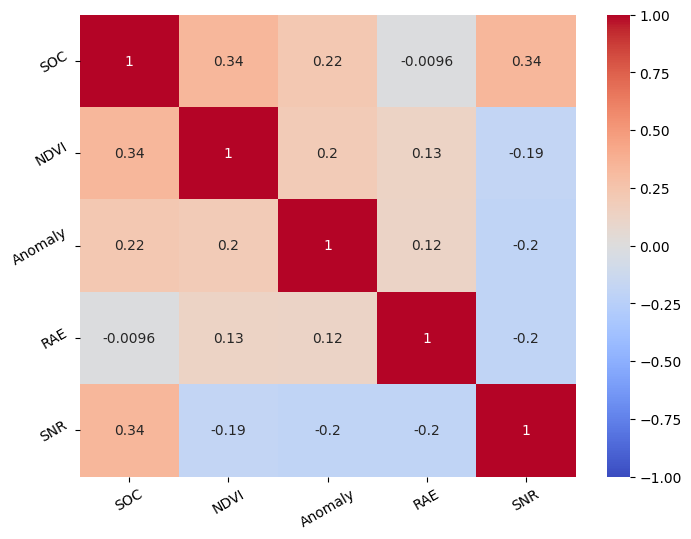

In [11]:
coe_pnt = test[['SOC','NDVI','Anomaly',r'RAE','SNR']].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe_pnt, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=30)
plt.show()

## plot together

/tmp/ipykernel_130889/36690720.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


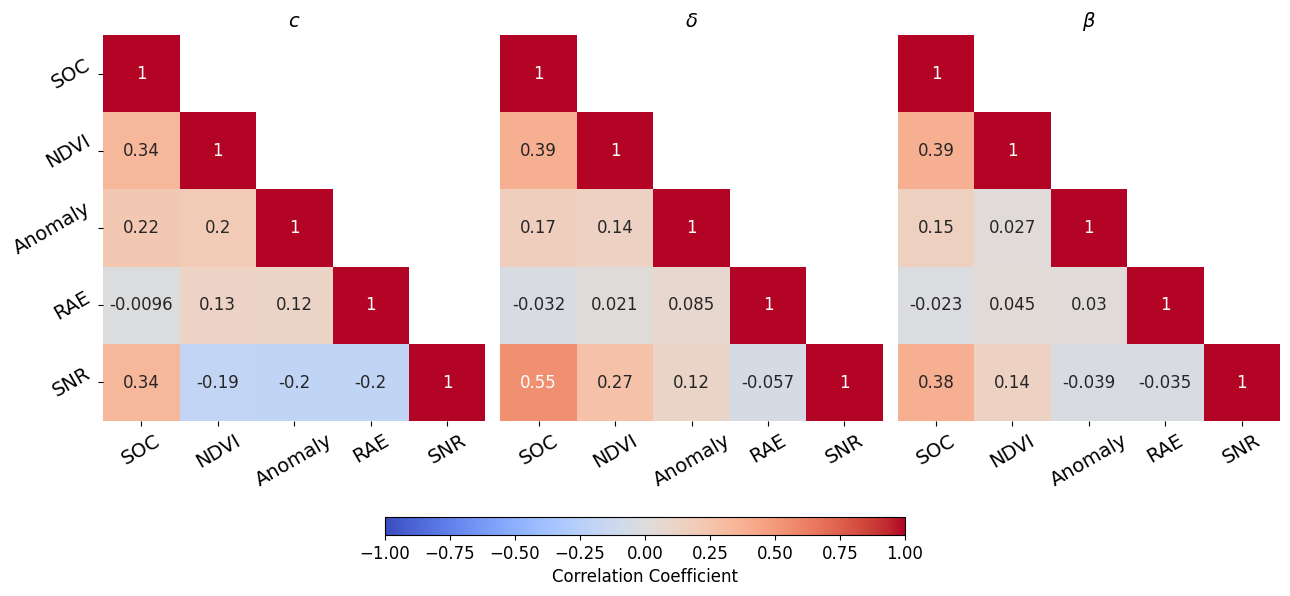

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

titles = [r'$c$', r'$\delta$', r'$\beta$']
matrices = [coe_pnt, coe_pair, coe_srs]
mask = np.triu(np.ones_like(coe_pnt, dtype=bool),k=1)

fig, axes = plt.subplots(1, 3, figsize=(13, 6))

vmin, vmax = -1, 1

for i, (ax, matrix, title) in enumerate(zip(axes, matrices, titles)):
    sns.heatmap(
        matrix,
        ax=ax,
        mask=mask,
        cmap="coolwarm",
        annot=True,
        vmin=vmin,
        vmax=vmax,
        center=0,
        cbar=False,
        annot_kws={"size": 12},
        yticklabels=(i == 0),  # Show y-tick labels only on the first plot
        # linewidths=0.5,
        # linecolor='black'
    )
    ax.set_title(title.capitalize(), fontsize=14)
    ax.tick_params(axis='x', rotation=30,labelsize=14)
    ax.tick_params(axis='y', rotation=30,labelsize=14)

cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.03])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Correlation Coefficient", fontsize=12)

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.savefig(f'./figure/plot_corr_metrics.pdf', bbox_inches='tight')
plt.show()
